In [1]:

import argparse
from pathlib import Path
from dotenv import load_dotenv
import os
import torch

from progen.sampling import sample, cross_entropy, truncate
from progen.utils import create_model, create_tokenizer_custom, set_env, set_seed, print_time


load_dotenv(verbose=True)
CHECKPOINT_DIR = os.environ.get('CHECKPOINT_DIR', './checkpoints')

/accounts/projects/jsteinhardt/fjiahai/progen-speculative-decoding/.venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
from progen.modeling_progen import apply_rotary_pos_emb, apply_rotary_pos_emb_pos, fixed_pos_embedding, rotate_every_two

import torch

In [3]:

models_151M = [ 'progen2-small' ]
models_754M = [ 'progen2-medium', 'progen2-oas', 'progen2-base' ]
models_2B = [ 'progen2-large', 'progen2-BFD90' ]
models_6B = [ 'progen2-xlarge' ]
models = models_151M + models_754M + models_2B + models_6B

In [4]:

parser = argparse.ArgumentParser()
parser.add_argument('--model', type=str, choices=models, default='progen2-large')
parser.add_argument('--device', type=str, default='cuda:0')
parser.add_argument('--rng-seed', type=int, default=42)
parser.add_argument('--rng-deterministic', default=True, type=lambda x: (str(x).lower() == 'true'))
parser.add_argument('--p', type=float, default=0.95)
parser.add_argument('--t', type=float, default=0.2)
parser.add_argument('--max-length', type=int, default=256)
parser.add_argument('--num-samples', type=int, default=1)
parser.add_argument('--fp16', default=True, type=lambda x: (str(x).lower() == 'true'))
parser.add_argument('--context', type=str, default='1')
parser.add_argument('--sanity', default=True, type=lambda x: (str(x).lower() == 'true'))
parser.add_argument('--flash-attention', default=False, type=lambda x: (str(x).lower() == 'true'))
parser.add_argument('--ragged-batches', default=False, type=lambda x: (str(x).lower() == 'true'))
args = parser.parse_args('--fp16 False --ragged-batches true --model progen2-small'.split(' '))

In [5]:
device = 'cuda'

In [6]:
ckpt = Path(CHECKPOINT_DIR) / args.model

In [7]:
model = create_model(ckpt=ckpt, fp16=args.fp16, flash_attention=args.flash_attention, ragged_batches=args.ragged_batches).to(device)

ProGenForCausalLM has generative capabilities, as `prepare_inputs_for_generation` is explicitly overwritten. However, it doesn't directly inherit from `GenerationMixin`. From 👉v4.50👈 onwards, `PreTrainedModel` will NOT inherit from `GenerationMixin`, and this model will lose the ability to call `generate` and other related functions.
  - If you're using `trust_remote_code=True`, you can get rid of this warning by loading the model with an auto class. See https://huggingface.co/docs/transformers/en/model_doc/auto#auto-classes
  - If you are the owner of the model architecture code, please modify your model class such that it inherits from `GenerationMixin` (after `PreTrainedModel`, otherwise you'll get an exception).
  - If you are not the owner of the model architecture class, please contact the model code owner to update it.


In [8]:
orig_model = create_model(ckpt=ckpt, fp16=args.fp16, flash_attention=False, ragged_batches=False).to(device)

In [9]:
tokenizer = create_tokenizer_custom(file='tokenizer.json')

In [10]:
from collections import UserDict

class D(UserDict):
    def to(self, device):
        for k, v in self.data.items():
            self.data[k] = v.to(device)
        return self
    def __getattr__(self, key):
        return self.data[key]
        

def pad_batch(input_ids, pad_token_id, padding_side='left'):
    '''
    Args:
        input_ids: List[List[int]]
        pad_token_id: int
        padding_side: 'left' | 'right'
    Returns:
        input_ids: Tensor
        attention_mask: tensor
    '''
    max_len = max(len(ls) for ls in input_ids)
    if padding_side == 'left':
        padded = [
            (max_len - len(seq)) * [pad_token_id] + seq
            for seq in input_ids
        ]
        attention_mask = [
            (max_len - len(seq)) * [0] + len(seq) * [1]
            for seq in input_ids
        ]
    else:
        padded = [
            seq + (max_len - len(seq)) * [pad_token_id]
            for seq in input_ids
        ]
        attention_mask = [
            len(seq) * [1] + (max_len - len(seq)) * [pad_token_id]
            for seq in input_ids
        ]
    return D(**{
        'input_ids': torch.tensor(padded, dtype=torch.long),
        'attention_mask': torch.tensor(attention_mask, dtype=torch.long)
    })
    

In [32]:
x_uniref90bfd30 = '2GFLPFRGADEGLAAREAATLAARGTAARAYREDSWAVPVPRGLLGDLTARVAALGAASPPPADPLAVTLDLHHVTAEVALTTVLDAATLVHGQTRVLSAEDAAEAATAAAAATEAYLERLQDFVLFMSASVRVWRRGNAAGATGPEWDQWYTVADRDALGSAPTHLAVLGRQADALCHFVLDRVAWGTCGTPLWSGDEDLGNVVATFAGYADRLATAPRDLIM1'
x1 = '2GLLGDLTARVAALGAASPPPADPLAVTLDLHHVTAEVALTTVLDAATLVHGQTRVLSAEDAAE1'
x2 = '2VA|LTTVLDAATLVHGQTRVLSAEDAAEAATAAAAATEAYLERLQDFVLFMSASVRVWRRGNAAGATGPEWDQWYTVADRDALGSAPT1'
x3 = '2EWDQWYTVADRDALGSAPTHLAVLGRQADALCHFVLDRVAWGTCGTPLWSGDEDLGNVVATFAGYADRLATAPRDLIMPPADPLAVTLDLHHVTAEVALTTVLDAATLVHGQTRVLSAEDAAEAATAAAA1'
inputs = tokenizer.encode_batch([x_uniref90bfd30, x1, x2, x3])

In [33]:
pad_token_id, = tokenizer.encode('<|pad|>').ids
inputs = pad_batch([x.ids for x in inputs], pad_token_id).to(device)

In [34]:
with torch.no_grad():
    outputs = model(**inputs, output_hidden_states=True)
    orig_outputs = orig_model(**inputs, output_hidden_states=True)

In [28]:
import seaborn as sns

In [29]:
def kl(p_logits, q_logits, dim=-1, keepdim=False):
    p_Z = p_logits.logsumexp(dim=dim, keepdim=True)
    p_probs = (p_logits - p_Z).exp()
    q_Z = q_logits.logsumexp(dim=dim, keepdim=True)
    return (p_probs * (p_logits - p_Z - q_logits + q_Z)).sum(dim=dim, keepdim=keepdim)
    

<Axes: >

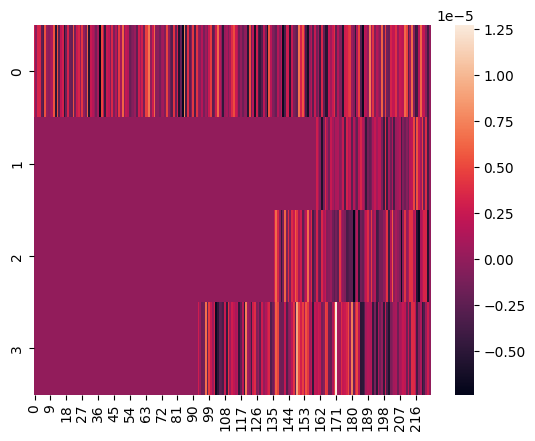

In [35]:
sns.heatmap(torch.where(inputs.attention_mask.bool(), kl(outputs.logits, orig_outputs.logits), 0).cpu().numpy())

<Axes: >

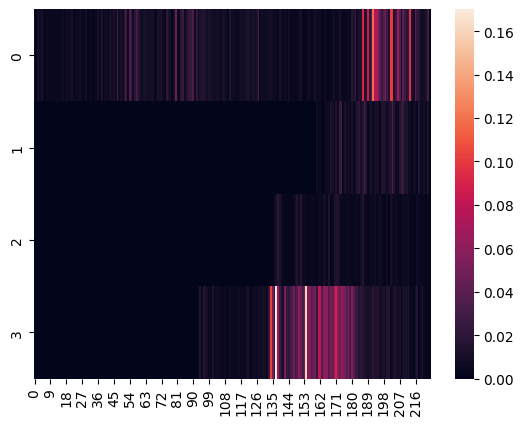

In [37]:
sns.heatmap(torch.where(inputs.attention_mask.bool(), (outputs.logits-orig_outputs.logits).norm(dim=-1), 0).cpu().numpy())

In [14]:
x_uniref90bfd30 = '2GFLPFRGADEGLAAREAATLAARGTAARAYREDSWAVPVPRGLLGDLTARVAALGAASPPPADPLAVTLDLHHVTAEVALTTVLDAATLVHGQTRVLSAEDAAEAATAAAAATEAYLERLQDFVLFMSASVRVWRRGNAAGATGPEWDQWYTVADRDALGSAPTHLAVLGRQADALCHFVLDRVAWGTCGTPLWSGDEDLGNVVATFAGYADRLATAPRDLIM1'
x1 = '2GLLGDLTARVAALGAASPPPADPLAVTLDLHHVTAEVALTTVLDAATLVHGQTRVLSAEDAAE1'
x2 = '2VA|LTTVLDAATLVHGQTRVLSAEDAAEAATAAAAATEAYLERLQDFVLFMSASVRVWRRGNAAGATGPEWDQWYTVADRDALGSAPT1'
x3 = '2EWDQWYTVADRDALGSAPTHLAVLGRQADALCHFVLDRVAWGTCGTPLWSGDEDLGNVVATFAGYADRLATAPRDLIMPPADPLAVTLDLHHVTAEVALTTVLDAATLVHGQTRVLSAEDAAEAATAAAA1'
inputs = tokenizer.encode_batch([x_uniref90bfd30])

In [39]:
pad_token_id, = tokenizer.encode('<|pad|>').ids
inputs = pad_batch([x.ids for x in inputs], pad_token_id).to(device)

In [40]:
with torch.no_grad():
    outputs = model(**inputs, output_hidden_states=True)
    orig_outputs = orig_model(**inputs, output_hidden_states=True)

<Axes: >

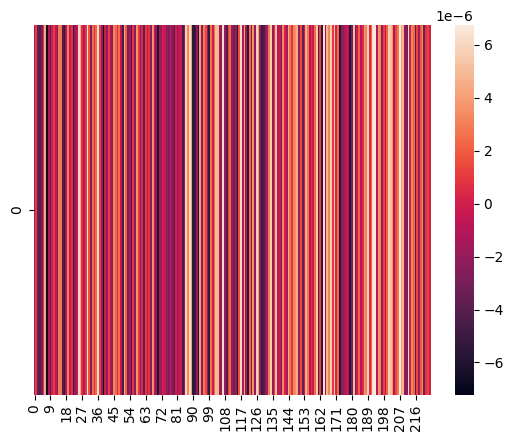

In [41]:
sns.heatmap(torch.where(inputs.attention_mask.bool(), kl(outputs.logits, orig_outputs.logits), 0).cpu().numpy())

<Axes: >

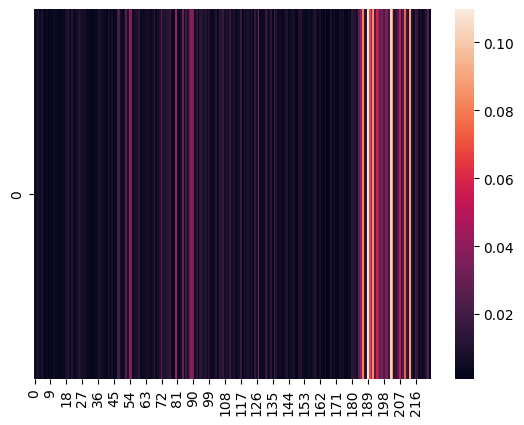

In [42]:
sns.heatmap(torch.where(inputs.attention_mask.bool(), (outputs.logits-orig_outputs.logits).norm(dim=-1), 0).cpu().numpy())

In [40]:
partial_inputs = tokenizer.encode_batch([
    x_uniref90bfd30[:30],
    x1[:15]
])

pad_token_id, = tokenizer.encode('<|pad|>').ids
partial_inputs = pad_batch([x.ids for x in partial_inputs], pad_token_id).to(device)


In [41]:
next_inputs = tokenizer.encode_batch([
    x_uniref90bfd30[30:40],
    x1[15:20]
])

pad_token_id, = tokenizer.encode('<|pad|>').ids
next_inputs = pad_batch([x.ids for x in next_inputs], pad_token_id).to(device)


In [42]:
full_outputs = tokenizer.encode_batch([
    x_uniref90bfd30[:40],
    x1[:20]
])

pad_token_id, = tokenizer.encode('<|pad|>').ids
full_outputs = pad_batch([x.ids for x in full_outputs], pad_token_id).to(device)


In [43]:
with torch.no_grad():
    outputs = model(**partial_inputs, output_hidden_states=True)
    # orig_outputs = orig_model(**inputs, output_hidden_states=True)
    kv_cache = outputs.past_key_values
    new_outputs = model(**next_inputs, use_cache=True, past_key_values=kv_cache)
    direct_outputs = model(**full_outputs)

In [47]:
torch.allclose(new_outputs.logits[0, -10:, :], direct_outputs.logits[0, -10:, :], 1e-3, 1e-3)

True

In [48]:
torch.allclose(new_outputs.logits[1, -5:, :], direct_outputs.logits[1, -5:, :], 1e-3, 1e-3)

True

In [58]:
(kv_cache[0][0][1]).shape

torch.Size([15, 16, 64])

In [53]:
tuple([1, 2, 3])

(1, 2, 3)

In [55]:
isinstance(kv_cache, tuple)

True

In [59]:
list(range(10))[:0]

[]